## Máster en Big Data y Data Science

### Metodologías de gestión y diseño de proyectos de big data

### Autora: MARITZA PINTA

#### AP2 - Modelado

---

En esta libreta se comienzan a ejecutar las actividades correspondientes a la fase de modelado. 

---

### Carga de librerias a utilizar

In [1]:
# Se importan las librerias a utilizar
import pandas as pd
import numpy as np

# Para registro de toda la experimentación
import mlflow

# Para la generación de los sets de train - test
from sklearn.model_selection import train_test_split

#Importaciones varias para la evaluación
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Lectura del dataset generado previamente

In [2]:
# Se hace la lectura del dataset del seminario y se obtiene su cabecera
datos = pd.read_csv('datos_finales.csv', sep=';')
datos.head()

,operaciones_ult_12m,gastos_ult_12m,limite_credito_tc,antiguedad_cliente,tasa_interes,ingresos,pct_ingreso,antiguedad_empleado,edad,estado_civil_N,...,importe_solicitado,duracion_credito,situacion_vivienda,objetivo_credito,falta_pago,estado_cliente,genero,nivel_educativo,nivel_tarjeta,personas_a_cargo
0,30_a_50,2k_a_4k,mayor_10k,2y_a_4y,7p_a_15p,hasta_20k,hasta_20,5_a_10,menor_25,C,...,1000,2,PROPIA,EDUCACIÓN,N,ACTIVO,M,SECUNDARIO_COMPLETO,Blue,3.0
1,15_a_30,2k_a_4k,3k_a_5k,2y_a_4y,15p_a_20p,50k_a_100k,40_a_60,5_a_10,menor_25,C,...,35000,2,ALQUILER,SALUD,N,ACTIVO,M,UNIVERSITARIO_COMPLETO,Blue,3.0
2,15_a_30,2k_a_4k,5k_a_10k,mayor_4y,7p_a_15p,50k_a_100k,40_a_60,5_a_10,menor_25,C,...,35000,4,ALQUILER,SALUD,Y,ACTIVO,M,DESCONOCIDO,Blue,1.0
3,15_a_30,2k_a_4k,3k_a_5k,2y_a_4y,7p_a_15p,hasta_20k,20_a_40,menor_5,menor_25,N,...,2500,2,PROPIA,INVERSIONES,N,ACTIVO,F,SECUNDARIO_COMPLETO,Blue,4.0
4,15_a_30,menor_1k,3k_a_5k,menor_2y,7p_a_15p,50k_a_100k,40_a_60,5_a_10,25_a_30,C,...,35000,3,ALQUILER,EDUCACIÓN,N,ACTIVO,M,UNIVERSITARIO_INCOMPLETO,Blue,3.0


### Revisión de meta-datos

In [3]:
def reporte_descripcion_dataset(df):
    columnas = df.columns
    print("Columnas del dataset:\n")
    for col in columnas:
        print(col)
    print(f"\nCantidad de filas: {df.shape[0]}")

print("Descripción del dataset 'datos_completos'")
reporte_descripcion_dataset(datos)

Descripción del dataset 'datos_completos'
Columnas del dataset:

operaciones_ult_12m
gastos_ult_12m
limite_credito_tc
antiguedad_cliente
tasa_interes
ingresos
pct_ingreso
antiguedad_empleado
edad
estado_civil_N
estado_credito_N
importe_solicitado
duracion_credito
situacion_vivienda
objetivo_credito
falta_pago
estado_cliente
genero
nivel_educativo
nivel_tarjeta
personas_a_cargo

Cantidad de filas: 9765


### Armado de los sets de entrenamiento y testeo

In [4]:
# Se separan los atributos de datos de los de la etiqueta del dataset

labels = datos.falta_pago.values

features = datos[['operaciones_ult_12m', 'gastos_ult_12m', 'limite_credito_tc',
       'antiguedad_cliente', 'tasa_interes', 'ingresos', 'pct_ingreso',
       'antiguedad_empleado', 'edad', 'importe_solicitado', 'duracion_credito',
       'situacion_vivienda', 'objetivo_credito', 'estado_civil_N',
       'estado_credito_N', 'estado_cliente', 'genero',
       'nivel_educativo', 'personas_a_cargo']]

print(f"Vista de los datos del atributo target: \n{labels[:10]}")
print("-"*50)
print("Vista parcial de los datos sin el atributo target:")
features.head()

Vista de los datos del atributo target: 
['N' 'N' 'Y' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
--------------------------------------------------
Vista parcial de los datos sin el atributo target:


,operaciones_ult_12m,gastos_ult_12m,limite_credito_tc,antiguedad_cliente,tasa_interes,ingresos,pct_ingreso,antiguedad_empleado,edad,importe_solicitado,duracion_credito,situacion_vivienda,objetivo_credito,estado_civil_N,estado_credito_N,estado_cliente,genero,nivel_educativo,personas_a_cargo
0,30_a_50,2k_a_4k,mayor_10k,2y_a_4y,7p_a_15p,hasta_20k,hasta_20,5_a_10,menor_25,1000,2,PROPIA,EDUCACIÓN,C,P,ACTIVO,M,SECUNDARIO_COMPLETO,3.0
1,15_a_30,2k_a_4k,3k_a_5k,2y_a_4y,15p_a_20p,50k_a_100k,40_a_60,5_a_10,menor_25,35000,2,ALQUILER,SALUD,C,C,ACTIVO,M,UNIVERSITARIO_COMPLETO,3.0
2,15_a_30,2k_a_4k,5k_a_10k,mayor_4y,7p_a_15p,50k_a_100k,40_a_60,5_a_10,menor_25,35000,4,ALQUILER,SALUD,C,C,ACTIVO,M,DESCONOCIDO,1.0
3,15_a_30,2k_a_4k,3k_a_5k,2y_a_4y,7p_a_15p,hasta_20k,20_a_40,menor_5,menor_25,2500,2,PROPIA,INVERSIONES,N,C,ACTIVO,F,SECUNDARIO_COMPLETO,4.0
4,15_a_30,menor_1k,3k_a_5k,menor_2y,7p_a_15p,50k_a_100k,40_a_60,5_a_10,25_a_30,35000,3,ALQUILER,EDUCACIÓN,C,C,ACTIVO,M,UNIVERSITARIO_INCOMPLETO,3.0


In [5]:
# Se pasa a binarizar los atributos

data = pd.get_dummies(features)
data.head()

,importe_solicitado,duracion_credito,personas_a_cargo,operaciones_ult_12m_15_a_30,operaciones_ult_12m_30_a_50,operaciones_ult_12m_50_a_75,operaciones_ult_12m_75_a_100,operaciones_ult_12m_mayor_100,operaciones_ult_12m_menor_15,gastos_ult_12m_2k_a_4k,...,estado_cliente_ACTIVO,estado_cliente_PASIVO,genero_F,genero_M,nivel_educativo_DESCONOCIDO,nivel_educativo_POSGRADO_COMPLETO,nivel_educativo_POSGRADO_INCOMPLETO,nivel_educativo_SECUNDARIO_COMPLETO,nivel_educativo_UNIVERSITARIO_COMPLETO,nivel_educativo_UNIVERSITARIO_INCOMPLETO
0,1000,2,3.0,False,True,False,False,False,False,True,...,True,False,False,True,False,False,False,True,False,False
1,35000,2,3.0,True,False,False,False,False,False,True,...,True,False,False,True,False,False,False,False,True,False
2,35000,4,1.0,True,False,False,False,False,False,True,...,True,False,False,True,True,False,False,False,False,False
3,2500,2,4.0,True,False,False,False,False,False,True,...,True,False,True,False,False,False,False,True,False,False
4,35000,3,3.0,True,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,True


In [6]:
# Para evitar problemas con mlfow se hace una conversión de integer a double 
# de los atributos: 'importe_solicitado', 'duracion_credito', 'estado_credito'

# Se filtran las columnas del tipo integer
integer_columns = data.select_dtypes(include='int').columns

# Convert integer columns to double
data[integer_columns] = data[integer_columns].astype('float')

In [7]:
# Definir la semilla global
SEED = 42  

# Se reparten los datos disponibles en conjuntos para entrenamiento y testeo
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.25, random_state=SEED  # Se añade random_state para reproducibilidad
)

# Toma por defecto 75% (entrenamiento) - 25% (testeo)

# Vista de los datos de entrenamiento para una fila

print(f"Un registro de entrenamiento: \n{train_data.iloc[1]}")
print("-"*50)
print(f"Label del registro: \n{train_labels[1]}\n")

print("#"*50)
print("#"*50)

# Vista de los datos de testeo para una fila

print(f"\nUn registro de testeo: \n{test_data.iloc[1]}")
print("-"*50)
print(f"Label del registro: \n{test_labels[1]}")

Un registro de entrenamiento: 
importe_solicitado                          4000.0
duracion_credito                               3.0
personas_a_cargo                               2.0
operaciones_ult_12m_15_a_30                  False
operaciones_ult_12m_30_a_50                  False
                                             ...  
nivel_educativo_POSGRADO_COMPLETO            False
nivel_educativo_POSGRADO_INCOMPLETO          False
nivel_educativo_SECUNDARIO_COMPLETO          False
nivel_educativo_UNIVERSITARIO_COMPLETO       False
nivel_educativo_UNIVERSITARIO_INCOMPLETO     False
Name: 8746, Length: 65, dtype: object
--------------------------------------------------
Label del registro: 
N

##################################################
##################################################

Un registro de testeo: 
importe_solicitado                          7500.0
duracion_credito                               2.0
personas_a_cargo                               4.0
operaciones_ult

In [8]:
# Configuración de la evaluación

def evaluar_modelo(modelo, test_data, test_labels):
    prediction = modelo.predict(test_data)
    print('Rendimiento obtenido:',accuracy_score(test_labels,prediction))
    print('Reporte de indicadores:\n',classification_report(test_labels,prediction))
    print('Matriz de confusión:')
    cm = confusion_matrix(test_labels, prediction, labels=modelo.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=modelo.classes_)
    disp.plot()
    plt.show()

In [9]:
# Para obtener todos los parámetros y no solo los modificados

from sklearn import set_config

set_config(print_changed_only=False)

### Generación de modelos

#### ZeroR

In [10]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier()
clf.fit(train_data, train_labels)

DummyClassifier(constant=None, random_state=None, strategy='prior')

In [11]:
prediction = clf.predict(test_data)

print('Rendimiento obtenido:',accuracy_score(test_labels, prediction))
print('Vista de una muestra de valores de predicción y datos de testeo:')
print(prediction[:10])
print(test_labels[:10])

Rendimiento obtenido: 0.8263718263718264
Vista de una muestra de valores de predicción y datos de testeo:
['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
['Y' 'N' 'N' 'Y' 'N' 'N' 'Y' 'N' 'N' 'N']


----
Se pasa a configurar la serie de experimentos en **mlflow**

In [29]:
# Se establece un nombre para identificar la serie de experimentos

mlflow.set_experiment(experiment_name="Prueba #1")
mlflow.autolog()

2025/03/09 08:32:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


#### Regresión Logística 1

In [30]:
from sklearn.linear_model import LogisticRegression

with mlflow.start_run(run_name='Logistic Regression'):
    lreg = LogisticRegression(solver='liblinear', random_state=42)

    lreg.fit(train_data, train_labels)

Rendimiento obtenido: 0.8665028665028665
Reporte de indicadores:
               precision    recall  f1-score   support

           N       0.90      0.95      0.92      2018
           Y       0.66      0.49      0.56       424

    accuracy                           0.87      2442
   macro avg       0.78      0.72      0.74      2442
weighted avg       0.86      0.87      0.86      2442

Matriz de confusión:


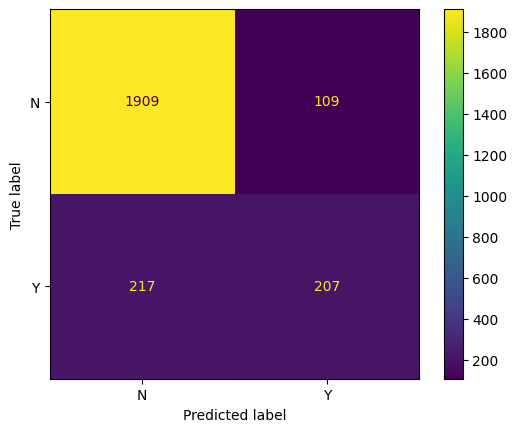

In [31]:
evaluar_modelo(lreg, test_data, test_labels)

#### KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier

with mlflow.start_run(run_name='KNN'):
    knn = KNeighborsClassifier(n_neighbors=50, 
                               algorithm = 'ball_tree', 
                               leaf_size = 25)

    knn.fit(train_data, train_labels)

Rendimiento obtenido: 0.8251433251433251
Reporte de indicadores:
               precision    recall  f1-score   support

           N       0.83      1.00      0.90      2018
           Y       0.29      0.00      0.01       424

    accuracy                           0.83      2442
   macro avg       0.56      0.50      0.46      2442
weighted avg       0.73      0.83      0.75      2442

Matriz de confusión:


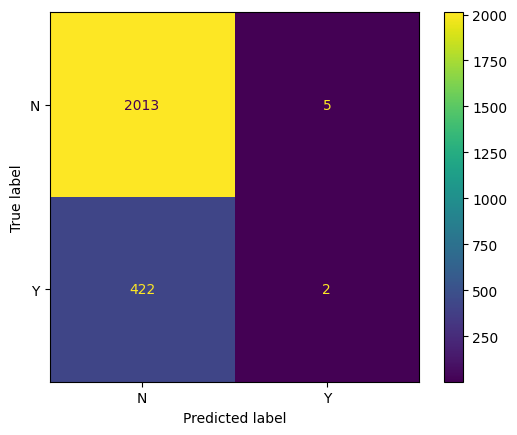

In [16]:
evaluar_modelo(knn, test_data, test_labels)

#### Árboles de Decisión (TDIDT)

In [17]:
from sklearn.tree import DecisionTreeClassifier

with mlflow.start_run(run_name='Decision Tree'):
    dtc = DecisionTreeClassifier(max_depth=3, 
                                 criterion='entropy', 
                                 min_samples_split=10,
                                 random_state=SEED)

    dtc.fit(train_data, train_labels)

Rendimiento obtenido: 0.8791973791973792
Reporte de indicadores:
               precision    recall  f1-score   support

           N       0.92      0.94      0.93      2018
           Y       0.68      0.58      0.63       424

    accuracy                           0.88      2442
   macro avg       0.80      0.76      0.78      2442
weighted avg       0.87      0.88      0.88      2442

Matriz de confusión:


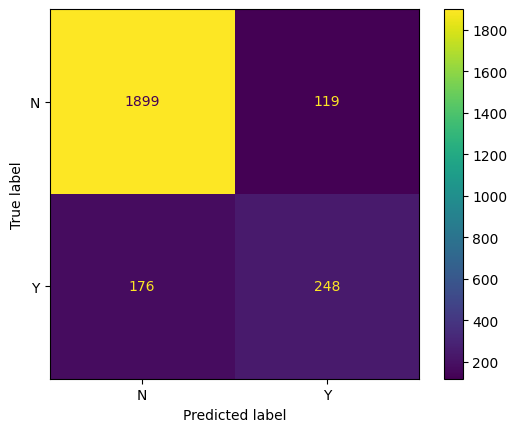

In [18]:
evaluar_modelo(dtc, test_data, test_labels)

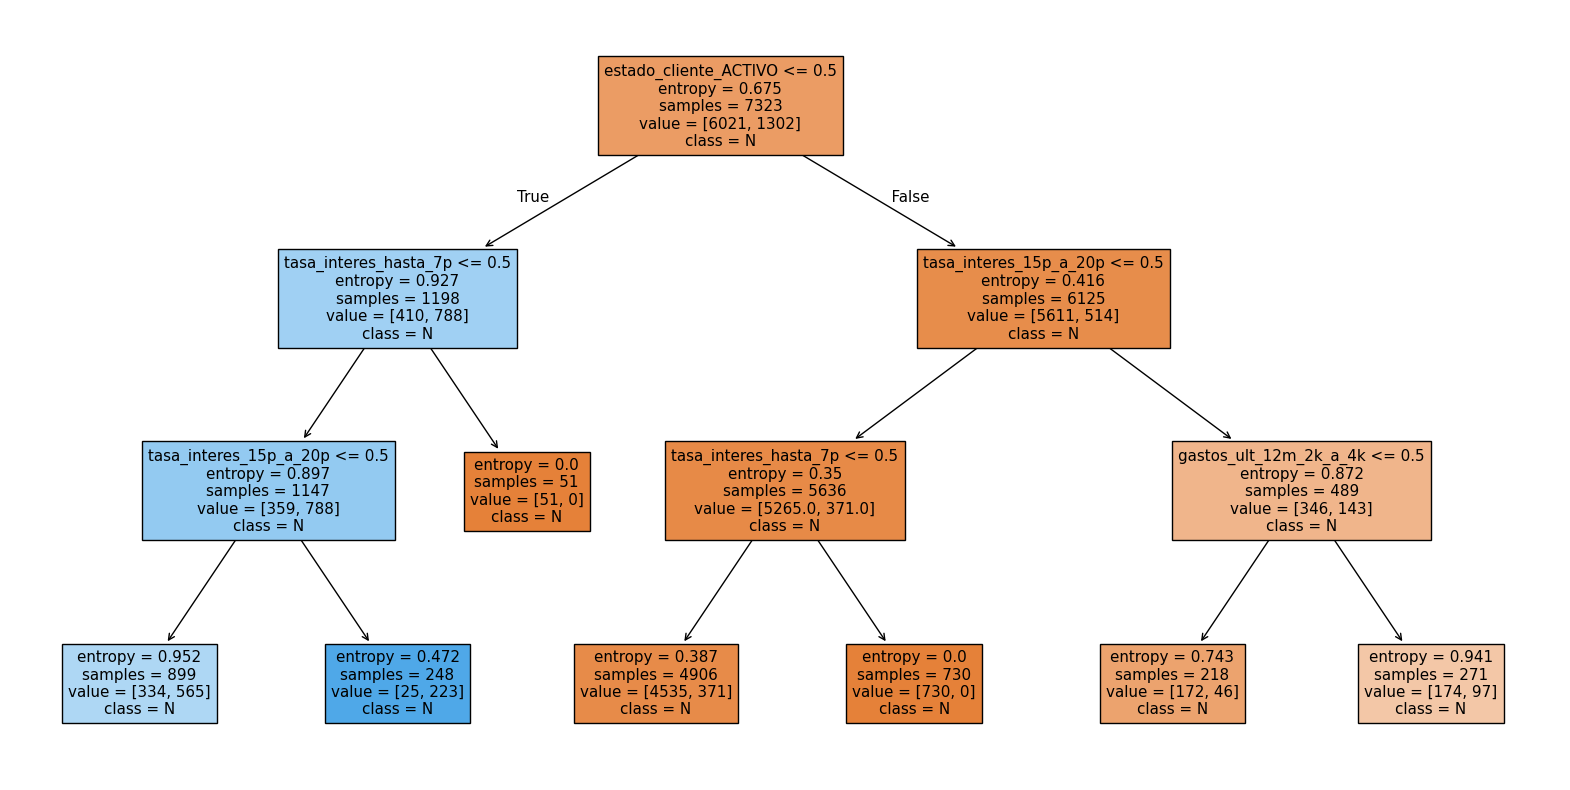

In [19]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(dtc, filled=True, feature_names=data.columns, class_names=labels)
plt.show()
plt.close()

#### Métodos de ensamblado de modelos: RandomForest

In [20]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run(run_name='Random Forest'):
    rndf = RandomForestClassifier(n_estimators=10,random_state=SEED)
    rndf.fit(train_data, train_labels)

Rendimiento obtenido: 0.8841113841113841
Reporte de indicadores:
               precision    recall  f1-score   support

           N       0.90      0.96      0.93      2018
           Y       0.75      0.50      0.60       424

    accuracy                           0.88      2442
   macro avg       0.82      0.73      0.77      2442
weighted avg       0.88      0.88      0.87      2442

Matriz de confusión:


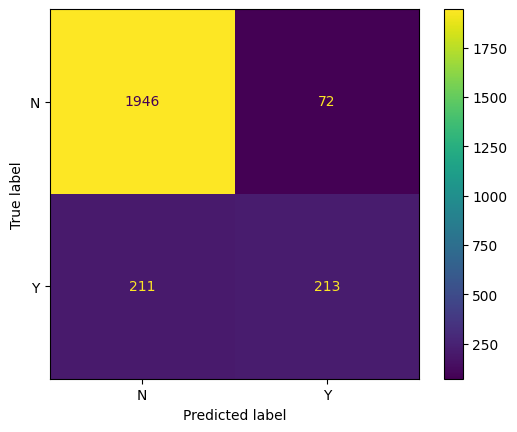

In [21]:
evaluar_modelo(rndf, test_data, test_labels)

----
PRUEBA #2

In [78]:
mlflow.set_experiment(experiment_name="Prueba 2")


<Experiment: artifact_location='file:///c:/MARITZA/ACTIVIDAD%20PRACTICA%202/mlruns/118661946854682651', creation_time=1741469175369, experiment_id='118661946854682651', last_update_time=1741469175369, lifecycle_stage='active', name='Prueba 2', tags={}>

#### Árboles de Decisión  2 (TDIDT)

In [79]:
with mlflow.start_run(run_name='Decision Tree (#2)'):
    dtc = DecisionTreeClassifier(max_depth=5, 
                                 criterion='gini', 
                                 min_samples_split=5,
                                 random_state=SEED)

    dtc.fit(train_data, train_labels)

Salida de resultado de la evaluación correspondientes a la Prueba #2
Rendimiento obtenido: 0.8783783783783784
Reporte de indicadores:
               precision    recall  f1-score   support

           N       0.92      0.94      0.93      2018
           Y       0.67      0.59      0.63       424

    accuracy                           0.88      2442
   macro avg       0.79      0.76      0.78      2442
weighted avg       0.87      0.88      0.88      2442

Matriz de confusión:


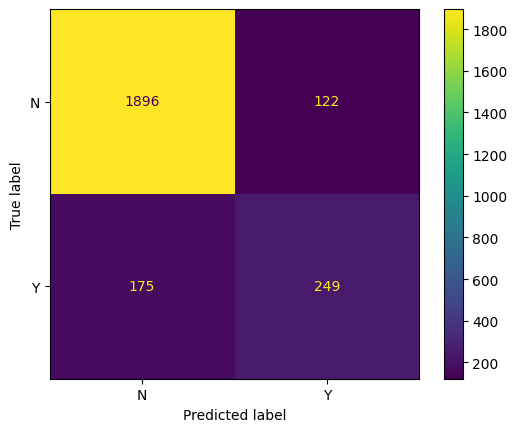

In [80]:
print("Salida de resultado de la evaluación correspondientes a la Prueba #2")
evaluar_modelo(dtc, test_data, test_labels)

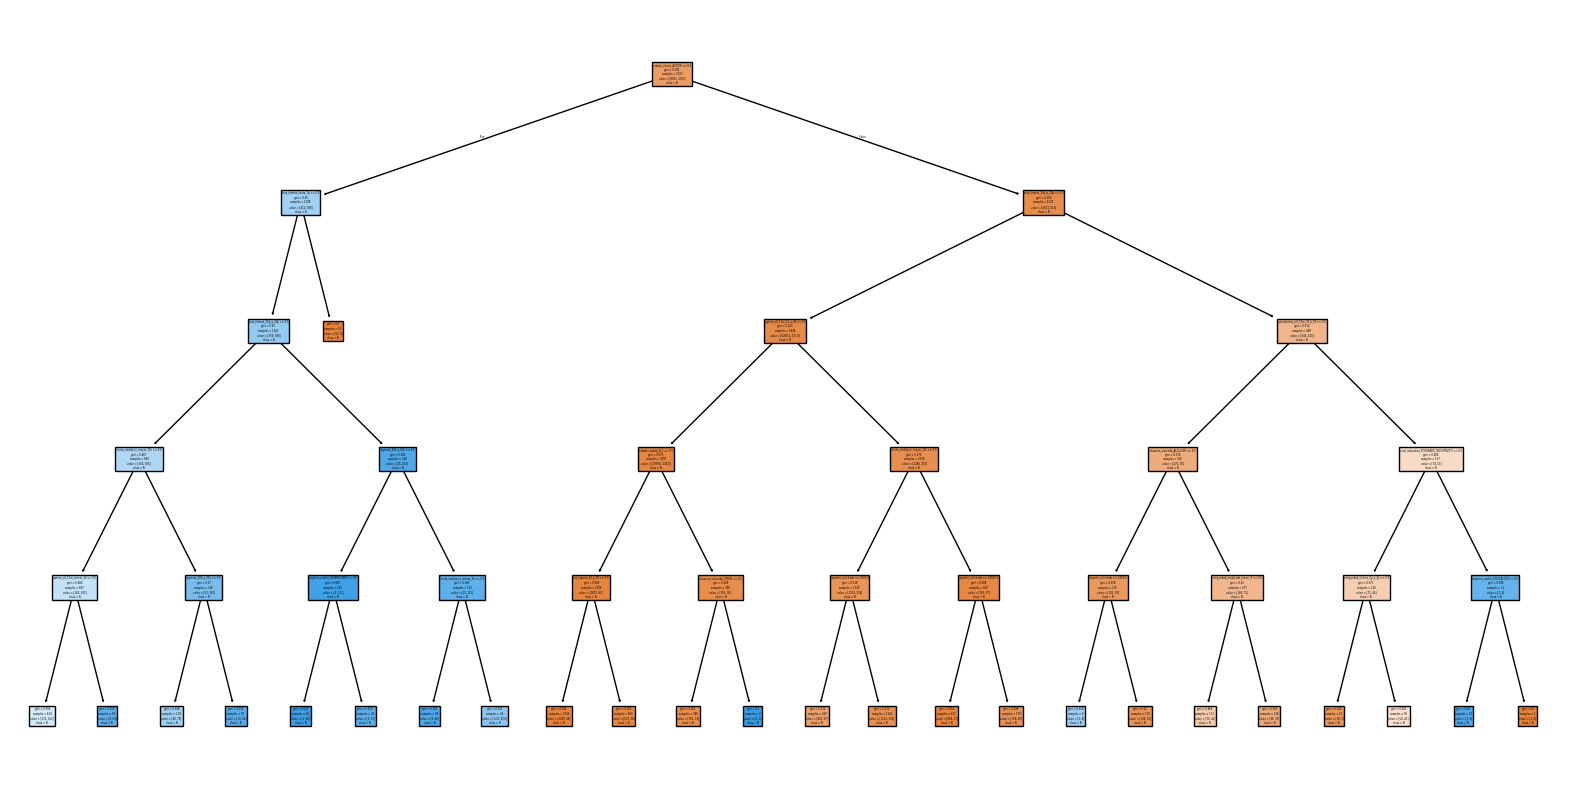

In [99]:
from sklearn.tree import plot_tree

# Plot the decision tree (#2)
plt.figure(figsize=(20,10))
plot_tree(dtc, filled=True, feature_names=data.columns, class_names=labels)
plt.show()
plt.close()

#### Regresión Logística 2

2025/03/08 19:52:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a735045482eb447a9eac4e1db8c33632', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/03/08 19:53:04 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


Rendimiento obtenido: 0.8505323505323505
Reporte de indicadores:
               precision    recall  f1-score   support

           N       0.94      0.88      0.91      2018
           Y       0.55      0.73      0.63       424

    accuracy                           0.85      2442
   macro avg       0.75      0.80      0.77      2442
weighted avg       0.87      0.85      0.86      2442

Matriz de confusión:


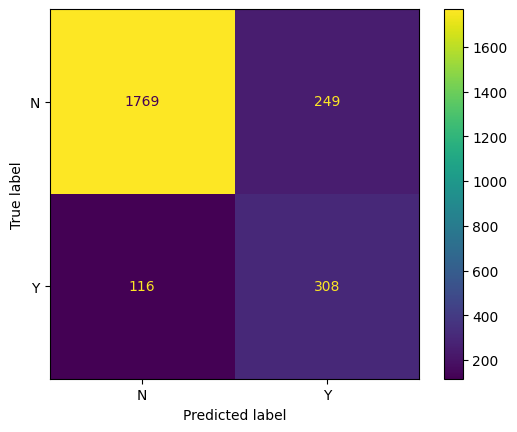

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import mlflow

# Estandarización de los datos
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Definir hiperparámetros para optimización
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Ajuste de regularización
    'penalty': ['l1', 'l2'],  # Tipo de regularización
    'solver': ['liblinear'],  # Compatible con l1 y l2
    'class_weight': ['balanced']  # Balanceo de clases
}

# Búsqueda de mejores hiperparámetros con validación cruzada
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(train_data_scaled, train_labels)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Entrenamiento con el mejor modelo
with mlflow.start_run(run_name='Logistic Regression Optimized'):
    best_model.fit(train_data_scaled, train_labels)

# Evaluación del modelo
evaluar_modelo(best_model, test_data_scaled, test_labels)


#### Métodos de ensamblado de modelos: RandomForest 2

In [102]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run(run_name='Random Forest 2'):
    rndf = RandomForestClassifier(n_estimators=100,random_state=SEED)
    rndf.fit(train_data, train_labels)

Rendimiento obtenido: 0.8910728910728911
Reporte de indicadores:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94      2018
           1       0.76      0.54      0.63       424

    accuracy                           0.89      2442
   macro avg       0.83      0.75      0.79      2442
weighted avg       0.88      0.89      0.88      2442

Matriz de confusión:


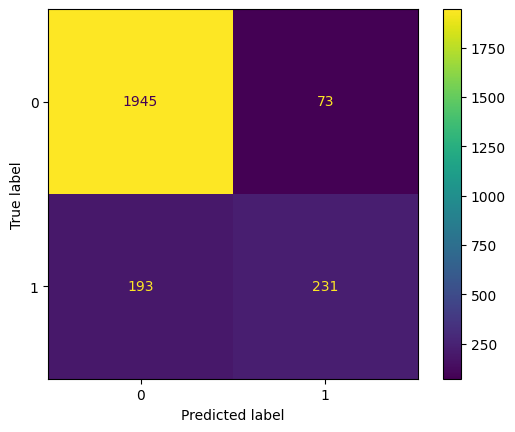

In [103]:
evaluar_modelo(rndf, test_data, test_labels)

#### XGBClassifier

In [140]:
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, log_loss

# Iniciar un experimento en MLflow
with mlflow.start_run(run_name='XGBClassifier'):
    # Crear y entrenar el modelo
    xgb = XGBClassifier(
        learning_rate=0.04287,
        max_depth=6,
        colsample_bytree=0.929650,
        gamma=4.81174,
        n_estimators=283,
        subsample=0.82164,
        random_state=SEED,
        eval_metric="logloss"
    )
    
    xgb.fit(train_data, train_labels)  # Solo entrenamiento

    # Hacer predicciones en entrenamiento
    train_predictions = xgb.predict(train_data)
    train_probs = xgb.predict_proba(train_data)[:, 1]  # Probabilidades clase positiva

    # Calcular métricas en entrenamiento
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_f1 = f1_score(train_labels, train_predictions)
    train_recall = recall_score(train_labels, train_predictions)
    train_precision = precision_score(train_labels, train_predictions)
    train_roc_auc = roc_auc_score(train_labels, train_probs)
    train_logloss = log_loss(train_labels, train_probs)

    # Registrar métricas en MLflow con los mismos nombres que los otros modelos
    mlflow.log_metric("training_accuracy_score", train_accuracy)
    mlflow.log_metric("training_f1_score", train_f1)
    mlflow.log_metric("training_recall_score", train_recall)
    mlflow.log_metric("training_precision_score", train_precision)
    mlflow.log_metric("training_roc_auc", train_roc_auc)
    mlflow.log_metric("training_log_loss", train_logloss)
    mlflow.log_metric("training_score", train_accuracy)  # Algunos modelos usan training_score en lugar de accuracy

    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(xgb, "XGBClassifier_model")



2025/03/09 00:14:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [00:14:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/03/09 00:15:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Rendimiento obtenido: 0.8886158886158886
Reporte de indicadores:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93      2018
           1       0.73      0.56      0.64       424

    accuracy                           0.89      2442
   macro avg       0.82      0.76      0.79      2442
weighted avg       0.88      0.89      0.88      2442

Matriz de confusión:


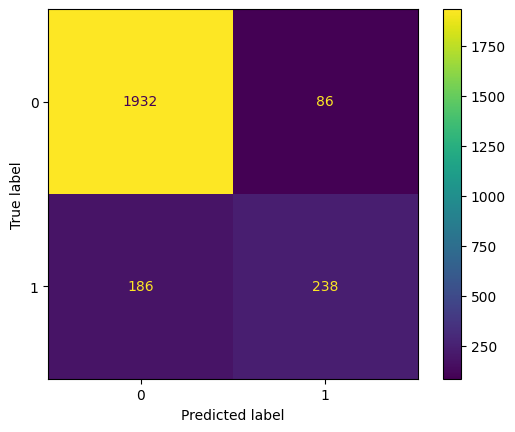

In [141]:
evaluar_modelo(xgb, test_data, test_labels)

----
PRUEBA #3

In [142]:
mlflow.set_experiment(experiment_name="Prueba #3")


2025/03/09 00:33:17 INFO mlflow.tracking.fluent: Experiment with name 'Prueba #3' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/MARITZA/ACTIVIDAD%20PRACTICA%202/mlruns/550629956585967618', creation_time=1741498397031, experiment_id='550629956585967618', last_update_time=1741498397031, lifecycle_stage='active', name='Prueba #3', tags={}>

#### TODO: posibilidades de mejora de la libreta

* Evaluación del clasificador a través de validación cruzada
* Ejecutar pruebas que contemplen datos con mayor o menor grado de transformaciones aplicadas 
* Implementar clasificación con otras técnicas (por ejemplo: redes neuronales, SVM, entre otras)
* Evaluar la combinación de técnicas, por ejemplo: clustering y sobre esos resultados aplicación de árboles de decisión para detectar patrones de agrupamiento y ahí relacionarlo con la situación de los clientes.
* Integrar técnicas de extracción de reglas de asociación (con mayor "legibilidad" para usuarios no-técnicos)
* Entre otras opciones

----

### Prueba de despliegue (utilzando datos nuevos)

In [93]:
datos_nuevos = pd.read_csv('datos_nuevos.csv', sep=';')
datos_nuevos.head(5)

,id_cliente,edad,importe_solicitado,duracion_credito,antiguedad_empleado,situacion_vivienda,ingresos,objetivo_credito,pct_ingreso,tasa_interes,...,antiguedad_cliente,estado_civil,estado_cliente,gastos_ult_12m,genero,limite_credito_tc,nivel_educativo,nivel_tarjeta,operaciones_ult_12m,personas_a_cargo
0,708510993,22,4000,4,3.0,HIPOTECA,62000,PERSONAL,0.06,6.76,...,47,SOLTERO,ACTIVO,15478.0,F,4905.0,UNIVERSITARIO_INCOMPLETO,Blue,109.0,1.0
1,708512051,25,10000,2,3.0,ALQUILER,120000,INVERSIONES,0.08,9.32,...,18,CASADO,ACTIVO,3950.0,M,1663.0,UNIVERSITARIO_COMPLETO,Blue,82.0,3.0
2,708513258,23,1700,2,2.0,HIPOTECA,45000,SALUD,0.04,14.72,...,29,CASADO,ACTIVO,3078.0,M,4323.0,UNIVERSITARIO_INCOMPLETO,Blue,58.0,1.0
3,708514512,25,7200,4,0.0,ALQUILER,71604,PAGO_DEUDAS,0.10,10.95,...,29,CASADO,ACTIVO,4314.0,F,3809.0,UNIVERSITARIO_INCOMPLETO,Blue,81.0,2.0
4,708515472,26,5000,3,5.0,HIPOTECA,52000,PAGO_DEUDAS,0.10,10.59,...,36,CASADO,ACTIVO,4216.0,F,4712.0,SECUNDARIO_COMPLETO,Blue,82.0,1.0


**Importante**: recordar que si se implementan operaciones de transformación sobre los datos será necesario (posiblemente) replicarlas sobre los datos nuevos para que ambos datasets sean compatibles.

#### Se tienen que aplicar las adaptaciones realizadas sobre los datos de entrenamiento

In [ ]:
# Columna: estado_civil
cambios_estado_civil = {
    'CASADO' : 'C',
    'SOLTERO' : 'S',
    'DESCONOCIDO' : 'N',
    'DIVORCIADO' : 'D',
}

estado_civil_N = datos_nuevos.loc[:, ('estado_civil')].map(cambios_estado_civil).rename('estado_civil')

# Columna: estado_credito
cambios_estado_credito = {
    0: 'C',
    1 : 'P',
}

estado_credito_N = datos_nuevos.loc[:, ('estado_credito')].map(cambios_estado_credito).rename('estado_credito')

# df_final = pd.concat([estado_civil_N, estado_credito_N, df_integrado], axis=1)
# df_final.head()

# Antiguedad del empleado

etiquetas_a_e = ['menor_10', '5_a_10', 'mayor_10']
rangos_a_e = [0, 4, 10, 50]
valor_para_nan = 'NA'
antiguedad_empleados_N = pd.cut(datos_nuevos['antiguedad_empleado'], 
                                bins=rangos_a_e, 
                                labels=etiquetas_a_e,
                                right=False).cat.add_categories(valor_para_nan).fillna(valor_para_nan)

# antiguedad_empleados_N.value_counts()

# edad

etiquetas_e = ['menor_25', '25_a_30']
rangos_e = [0, 24, 50]
edad_N = pd.cut(datos_nuevos['edad'], 
                                bins=rangos_e, 
                                labels=etiquetas_e)

# edad_N.value_counts()

# pct_ingreso

etiquetas_p_i = ['hasta_20', '20_a_40', '40_a_60', 'mayor_60']
rangos_p_i = [0, 0.19, 0.39, 0.60, 0.99]
pct_ingreso_N = pd.cut(datos_nuevos['pct_ingreso'], 
                                bins=rangos_p_i, 
                                labels=etiquetas_p_i)

# pct_ingreso_N.value_counts()

# ingresos

etiquetas_i = ['hasta_20k', '20k_a_50k', '50k_a_100k', 'mayor_100k']
rangos_i = [0, 19999, 49999, 99999, 999999]
ingresos_N = pd.cut(datos_nuevos['ingresos'], 
                                bins=rangos_i, 
                                labels=etiquetas_i)

# ingresos_N.value_counts()

# tasa_interes

etiquetas_t_i = ['hasta_7p', '7p_a_15p', '15p_a_20p', 'mayor_20p']
rangos_t_i = [0, 6.99, 14.99, 19.99, 100]
tasa_interes_N = pd.cut(datos_nuevos['tasa_interes'], 
                                bins=rangos_t_i, 
                                labels=etiquetas_t_i)

# tasa_interes_N.value_counts()

# antiguedad_cliente

etiquetas_a_c = ['menor_2y', '2y_a_4y', 'mayor_4y']
rangos_a_c = [0, 24, 48, 100]
antiguedad_cliente_N = pd.cut(datos_nuevos['antiguedad_cliente'], 
                                bins=rangos_a_c, 
                                labels=etiquetas_a_c)

# antiguedad_cliente_N.value_counts()

# limite_credito_tc

etiquetas_l_tc = ['menor_3k', '3k_a_5k', '5k_a_10k', 'mayor_10k']
rangos_l_tc = [0, 2999, 4999, 9999, 100000]
limite_credito_tc_N = pd.cut(datos_nuevos['limite_credito_tc'], 
                                bins=rangos_l_tc, 
                                labels=etiquetas_l_tc)

# limite_credito_tc_N.value_counts()

# gastos_ult_12m

etiquetas_g_u12 = ['menor_1k', '2k_a_4k', '4k_a_6k', '6k_a_8k', '8k_a_10k', 'mayor_10k']
rangos_g_u12 = [0, 999, 3999, 5999, 7999, 9999, 100000]
gastos_ult_12m_N = pd.cut(datos_nuevos['gastos_ult_12m'], 
                                bins=rangos_g_u12, 
                                labels=etiquetas_g_u12)

# gastos_ult_12m_N.value_counts()

# operaciones_ult_12m

etiquetas_o_u12 = ['menor_15', '15_a_30', '30_a_50', '50_a_75', '75_a_100', 'mayor_100']
rangos_o_u12 = [0, 14, 29, 49, 74, 99, 1000]
operaciones_ult_12m_N = pd.cut(datos_nuevos['operaciones_ult_12m'], 
                                bins=rangos_o_u12, 
                                labels=etiquetas_o_u12)

# operaciones_ult_12m_N.value_counts()

col_eliminar_final = [
              'edad',
              'antiguedad_empleado',
              'antiguedad_cliente', 
              'ingresos',
              'pct_ingreso', 
              'tasa_interes',
              'gastos_ult_12m', 
              'limite_credito_tc', 
              'operaciones_ult_12m',
              'nivel_tarjeta',
              'estado_civil',
              'estado_credito',
              'id_cliente']

datos_nuevos.drop(col_eliminar_final, inplace=True, axis=1)


df_nuevo = pd.concat([operaciones_ult_12m_N, gastos_ult_12m_N, limite_credito_tc_N, antiguedad_cliente_N, tasa_interes_N, ingresos_N, pct_ingreso_N, antiguedad_empleados_N, edad_N, estado_civil_N, estado_credito_N, datos_nuevos], axis=1)
df_nuevo.head(5)

In [ ]:
nuevos_codif = pd.get_dummies(df_nuevo)
nuevos_codif.info()

In [ ]:
# Dado que puede haber diferencias con el set de entrenamiento se emparejan

columnas_faltantes = set(data.columns) - set(nuevos_codif.columns)
display(columnas_faltantes)
for columna in columnas_faltantes:
    nuevos_codif[columna] = 0 # Se agregan las columnas faltantes con valor 0

print('Datos nuevos: ' + str(len(nuevos_codif.columns)))
print('Datos entrenamiento: ' + str(len(data.columns)))
print(set(data.columns) - set(nuevos_codif.columns))

In [ ]:
nuevos_codif = nuevos_codif[data.columns]
nuevos_codif.columns

In [ ]:
# Se hace la predicción con los nuevos datos

prediccion_nuevos = dtc.predict(nuevos_codif)

prediccionDF = pd.DataFrame(prediccion_nuevos)

In [ ]:
# Se agrega la nueva columna
datos_nuevos['prediccion_mora'] = prediccionDF
datos_nuevos['prediccion_mora'].value_counts()